## This botebook is to build machine learning classifier for predicting H-D-A or double chance.

Feature engineering idea is borrowed from paper:

>Regression models for forecasting goals and match results in association football, John Goddard (2005).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Feature Engineering

In [2634]:
from football.datasets import load_EPL,load_Spain,load_France,load_Germany,load_Italy

f1, f2, f3, f4, f5 = load_EPL, load_Spain, load_France, load_Germany, load_Italy
# choose a league
load_league = f1

df1 = pd.concat([load_league('2008-2009').data, load_league('2009-2010').data], ignore_index=True)
df2 = pd.concat([load_league('2010-2011').data, load_league('2011-2012').data, load_league('2012-2013').data, load_league('2013-2014').data, load_league('2014-2015').data], \
                      ignore_index=True)

In [3]:
def FeatureEngineer(df1, df2, which_predictors = range(1, 28), real_predict=False):
    '''
    Return a dataframe of predictors given the raw dataset.

    Predictors:
    -------------------------------------------------------------------------
    x1:  average number of goals scored by team i, past 0~12 months
    x2:  average number of goals scored by team i, past 12~24 months
    x3:  average number of goals conceded by team i, past 0~12 months
    x4:  average number of goals conceded by team i, past 12~24 months

    x5:  average number of goals scored by team j, past 0~12 months
    x6:  average number of goals scored by team j, past 12~24 months
    x7:  average number of goals conceded by team j, past 0~12 months
    x8:  average number of goals conceded by team j, past 12~24 months
    -------------------------------------------------------------------------
    x9:  average match results team i, past 0~12 months
    x10: average match results team i, past 12~24 months
    x11: average match results team j, past 0~12 months
    x12: average match results team j, past 12~24 months
    (win=1, draw=0.5,lose=0)
    -------------------------------------------------------------------------
    x13: goals scored at home team i, recent 5 matches
    x14: goals scored away team i, recent 5 matches
    x15: goals conceded at home team i, recent 5 matches
    x16: goals conceded away team i, recent 5 matches

    x17: goals scored at home team j, recent 5 matches
    x18: goals scored away team j, recent 5 matches
    x19: goals conceded at home team j, recent 5 matches
    x20: goals conceded away team j, recent 5 matches
    -------------------------------------------------------------------------
    x21: match results at home team i, recent 5 matches
    x22: match results away team i, recent 5 matches
    x23: match results at home team j, recent 5 matches
    x24: match results away team j, recent 5 matches
    (win=1, draw=0.5,lose=0)
    -------------------------------------------------------------------------

    x25: home win odds
    x26: draw odds
    x27: away win odds

    -------------------------------------------------------------------------

    Parameters:

    df1: pd.DataFrame, [season1, season2]
    df2: pd.DataFrame, [season3, season4,...]
    which_predictors: list, decide which predictors to use, e.g. range(1, 11) + [25,26,27]
    real_predict: True, False. for real pre-match betting, match outcomes are unknown before kick-off

    '''

    N_past = len(df1.Date)
    N_train = len(df2.Date)

    # FTR is not known for real pre-match betting
    if real_predict:
        #convert FTR to match points
        valH, valA = {'H':1.0, 'D':0.5, 'A':0.0}, {'H':0.0, 'D':0.5, 'A':1.0}
        df1['FTRH'] = [valH[res] for res in df1.FTR]
        df1['FTRA'] = [valA[res] for res in df1.FTR]
        #df2.fillna(0)
        dataset = pd.concat([df1,df2], ignore_index=True)[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'FTRH', 'FTRA']]
    # just doing researching on historic dataset, results are all known
    else:
        dataset = pd.concat([df1,df2], ignore_index=True)[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
        #convert FTR to match points
        valH, valA = {'H':1.0, 'D':0.5, 'A':0.0}, {'H':0.0, 'D':0.5, 'A':1.0}
        dataset['FTRH'] = [valH[res] for res in dataset.FTR]
        dataset['FTRA'] = [valA[res] for res in dataset.FTR]

    all_predictors = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14', \
                     'x15','x16','x17','x18','x19','x20','x21','x22','x23','x24', 'x25', 'x26', 'x27']
    use_predictors = [u for (i,u) in enumerate(all_predictors) if (i+1) in which_predictors]

    predictors = \
    pd.DataFrame([[0.0]*len(use_predictors)]*N_train, dtype=float, \
             columns=use_predictors \
            )

    print 'Feature Engineering Task(part by part)\n\nPart 1 Loading.'
    #-------------------------------------------------------------------------------------------------------------

    if 'x1' in use_predictors:
        #x1:  average number of goals scored by team i, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x1'] = [f(i) for i in range(N_train)]
    if 'x2' in use_predictors:
        #x2:  average number of goals scored by team i, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x2'] = [f(i) for i in range(N_train)]
    if 'x3' in use_predictors:
        #x3:  average number of goals conceded by team i, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x3'] = [f(i) for i in range(N_train)]
    if 'x4' in use_predictors:
        #x4:  average number of goals conceded by team i, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x4'] = [f(i) for i in range(N_train)]

    if 'x5' in use_predictors:
        #x5:  average number of goals scored by team j, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x5'] = [f(i) for i in range(N_train)]
    if 'x6' in use_predictors:
        #x6:  average number of goals scored by team j, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x6'] = [f(i) for i in range(N_train)]
    if 'x7' in use_predictors:
        #x7:  average number of goals conceded by team j, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x7'] = [f(i) for i in range(N_train)]
    if 'x8' in use_predictors:
        #x8:  average number of goals conceded by team j, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x8'] = [f(i) for i in range(N_train)]

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 2 Loading.'

    if 'x9' in use_predictors:
        #x9:  average match results team i, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x9'] = [f(i) for i in range(N_train)]
    if 'x10' in use_predictors:
        #x10: average match results team i, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRH'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRA'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x10'] = [f(i) for i in range(N_train)]
    if 'x11' in use_predictors:
        #x11: average match results team j, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x11'] = [f(i) for i in range(N_train)]
    if 'x12' in use_predictors:
        #x12: average match results team j, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRH'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRA'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x12'] = [f(i) for i in range(N_train)]
        #(win=1, draw=0.5,lose=0)

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 3 Loading.'

    if 'x13' in use_predictors:
        #x13: goals scored at home team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x13'] = [f(i) for i in range(N_train)]
    if 'x14' in use_predictors:
        #x14: goals scored away, team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x14'] = [f(i) for i in range(N_train)]
    if 'x15' in use_predictors:
        #x15: goals conceded at home team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x15'] = [f(i) for i in range(N_train)]
    if 'x16' in use_predictors:
        #x16: goals conceded away, team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x16'] = [f(i) for i in range(N_train)]

    if 'x17' in use_predictors:
        #x17: goals scored at home team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x17'] = [f(i) for i in range(N_train)]
    if 'x18' in use_predictors:
        #x18: goals scored away team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x18'] = [f(i) for i in range(N_train)]
    if 'x19' in use_predictors:
        #x19: goals conceded at home team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x19'] = [f(i) for i in range(N_train)]
    if 'x20' in use_predictors:
        #x20: goals conceded away team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x20'] = [f(i) for i in range(N_train)]

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 4 Loading.'

    if 'x21' in use_predictors:
        #x21: match results at home team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x21'] = [f(i) for i in range(N_train)]
    if 'x22' in use_predictors:
        #x22: match results away, team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x22'] = [f(i) for i in range(N_train)]
    if 'x23' in use_predictors:
        #x23: match results at home team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x23'] = [f(i) for i in range(N_train)]
    if 'x24' in use_predictors:
        #x24: match results away, team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x24'] = [f(i) for i in range(N_train)]
        #(win=1, draw=0.5,lose=0)

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 5 Loading.'

    #x25: win-draw-win odds for each match, on train dataset
    if 'x25' in use_predictors:
        # assign a col to another, the indexes of these two columns must be identical
        predictors['x25'] = df2.reset_index(drop=True)['B365H']
    if 'x26' in use_predictors:
        predictors['x26'] = df2.reset_index(drop=True)['B365D']
    if 'x27' in use_predictors:
        predictors['x27'] = df2.reset_index(drop=True)['B365A']


    #-------------------------------------------------------------------------------------------------------------
    print '\nFinishing.'

    return predictors



def ResponseEngineer(dataset, which=0):
    '''
    Return a list of response.

    Response:

    which=0, default
    y = 0, home win
    y = 1, draw
    y = 2, away win

    Other types: see [val0, val1, val2, val3]

    --------------------------------------------
    Parameters:

    dataset: pd.DataFrame, training df2
    which: int, 0~3

    '''
    val0 = {'H':0, 'D':1, 'A':2}
    val1 = {'H':0, 'D':1, 'A':1}
    val2 = {'D':0, 'H':1, 'A':1}
    val3 = {'A':0, 'H':1, 'D':1}

    # choose a type from [val0, val1, val2, val3]
    val = [val0, val1, val2, val3][which]
    return [val[res] for res in dataset.FTR]

In [2930]:
# e.g. x1, x2,..., x24
X = FeatureEngineer(df1, df2, which_predictors=range(1,25), real_predict=False)

Feature Engineering Task(part by part)

Part 1 Loading.
Part 2 Loading.
Part 3 Loading.
Part 4 Loading.
Part 5 Loading.

Finishing.


In [2931]:
y = ResponseEngineer(df2, which=2)

In [2636]:
X.loc[0:4, ]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
0,1.368421,1.421053,1.026316,1.263158,1.236842,1.105263,1.736842,1.184211,0.618421,0.592105,...,0,0,1,0,1,0,0,0,0.5,0
1,1.078947,1.052632,1.447368,1.578947,1.578947,1.447368,1.289474,0.973684,0.486842,0.407895,...,0,0,1,0,0,0,0,0,1.0,0
2,1.105263,1.078947,1.763158,1.394737,1.026316,1.026316,1.210526,0.894737,0.381579,0.394737,...,0,0,0,0,0,0,0,0,0.0,0
3,2.710526,1.789474,0.842105,0.631579,0.000000,0.947368,0.000000,1.763158,0.776316,0.763158,...,0,0,0,0,0,0,0,0,0.0,0
4,1.263158,0.894737,1.473684,1.421053,1.000000,0.000000,1.236842,0.000000,0.434211,0.355263,...,0,2,0,0,0,0,0,0,0.0,0


In [2932]:
y[0:4]

[1, 1, 0, 1]

## Training & Validation

In [8]:
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

### first classifier: a simple SVM

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
# Set the parameters by cross-validation
tuned_parameters = \
[{'kernel': ['rbf'], 'gamma': np.logspace(-4, 3, 8), 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}, \
{'kernel': ['linear'], 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}, \
{'kernel':['poly'], 'degree':[1,2,3,4,5,6,7,8,9,10], 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}]

scores = ['recall', 'precision']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score + '\n'

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:"
    print clf.best_params_
    print '\n'
    print "Grid scores on development set:"
    print '\n'
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print '\n'

    print "Detailed classification report:"
    print '\n'
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print '\n'
    # prediction on validation dataset
    y_true, y_pred = y_test, clf.predict(X_test)
    print 'validation dataset'
    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    print '\n'
    # fit on train dataset
    y_true, y_pred = y_train, clf.predict(X_train)
    print 'train dataset'
    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    print '\n'

# Tuning hyper-parameters for recall

Best parameters set found on development set:
{'kernel': 'linear', 'C': 0.3}


Grid scores on development set:


0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.0001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.01}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.10000000000000001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 1.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 10.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 100.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 1000.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.0001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.01}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.10000000000000001}
0.457 (+/-0.003) fo

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
# parameters = {'C':[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
# clf = LinearSVC(penalty='l2', loss='l2', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None)
parameters = {'kernel': ['rbf'], 'gamma': np.logspace(-4, 3, 8), 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
clf = SVC()

# try to improve recall
gs = GridSearchCV(clf, param_grid=parameters, cv=10, scoring='precision')
gs.fit(X_train, y_train)
#print gs.grid_scores_
print gs.best_params_, gs.best_score_

# prediction on validation dataset
y_true, y_pred = y_test, gs.predict(X_test)
print 'validation dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'
# fit on train dataset
y_true, y_pred = y_train, gs.predict(X_train)
print 'train dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'

print \
'''
Precision and Recall:

When a search engine returns 30 pages only 20 of which were relevant while failing 
to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3.
'''

{'kernel': 'rbf', 'C': 3.0, 'gamma': 1.0} 0.762687001819
validation dataset
             precision    recall  f1-score   support

          0       0.24      0.10      0.14        42
          1       0.82      0.93      0.87       186

avg / total       0.71      0.78      0.74       228

[[  4  38]
 [ 13 173]]


train dataset
             precision    recall  f1-score   support

          0       0.98      0.84      0.90       219
          1       0.95      0.99      0.97       693

avg / total       0.96      0.96      0.96       912

[[184  35]
 [  4 689]]



Precision and Recall:

When a search engine returns 30 pages only 20 of which were relevant while failing 
to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3.



## Deeper

### unbalanced labels problem, home win 50%, draw 20%, away win 30%

In [3194]:
import random
#from sklearn.cross_validation import StratifiedShuffleSplit

N_all_samples = len(y)
N_draw_samples = (np.array(y)==0).sum()
N_HA_samples = N_all_samples - N_draw_samples
y_draw = [0]*N_draw_samples
y_HA = [1]*N_draw_samples

X_draw = X[np.array(y)==0]
_X_HA = X[np.array(y)==1]
X_draw.reset_index(drop=True, inplace=True)
_X_HA.reset_index(drop=True, inplace=True)
# draw matches are fewer, randomly subset the HA matches to be same length as draw.
index = random.sample( set(range(N_HA_samples)), N_draw_samples )
X_HA = _X_HA.ix[index,:]
X_HA.reset_index(drop=True, inplace=True)

_X = pd.concat([X_draw, X_HA], ignore_index=True)
_y = y_draw + y_HA

### try ensemble methods
>improving the precision of recognizing Draw games to 40%+, since odds for draw normally 3.0+

In [2435]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [3215]:
# which =  0.HDA, 1.H DA, 2.D HA, 3.A HD
# y = ResponseEngineer(df2, which=2)
#
X_train, X_test, y_train, y_test = train_test_split(_X, _y, train_size=0.8)

# unbalanced sample. 0 draw : 1 HA = 0.3 : 0.7
#sample_weight = np.array([2 if i == 0 else 1 for i in y_train])


#gs = SVC(C=1.0, gamma=0.3, kernel='rbf', class_weight={0:1.8, 1:0.9})
#gs = BaggingClassifier(base_estimator=SVC(C=1.0, gamma=0.3, kernel='rbf', class_weight={0:1.6, 1:1.0}), n_estimators=50)
#gs = BaggingClassifier(base_estimator=SVC(C=1.0, gamma=0.3, kernel='poly', degree=3, class_weight={0:1.6, 1:1.0}), n_estimators=50)
#gs = AdaBoostClassifier(base_estimator=SVC(C=1.0, gamma=1.0, kernel='rbf', class_weight={0:1.6, 1:1.0}), n_estimators=50, algorithm='SAMME')
#gs = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=5), n_estimators=50)
#gs = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5)
#gs = AdaBoostClassifier(base_estimator=SGDClassifier(class_weight={0:1.6, 1:1.0}), n_estimators=500, algorithm='SAMME')
#gs = BaggingClassifier(LogisticRegression(C=1.0), n_estimators=50)
gs = RandomForestClassifier(n_estimators=10)
gs.fit(X_train, y_train)
#gs.fit(X_train, y_train, sample_weight=sample_weight)

# prediction on validation dataset
y_true, y_pred = y_test, gs.predict(X_test)
print 'validation dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'
# fit on train dataset
y_true, y_pred = y_train, gs.predict(X_train)
print 'train dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'

#print 'predict: ', gs.predict(test_X)

validation dataset
             precision    recall  f1-score   support

          0       0.51      0.62      0.56        94
          1       0.56      0.45      0.50       100

avg / total       0.54      0.53      0.53       194

[[58 36]
 [55 45]]


train dataset
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       389
          1       0.99      0.97      0.98       383

avg / total       0.98      0.98      0.98       772

[[385   4]
 [ 13 370]]




## Out-of-sample test

In [3115]:
# 10 new matches, real_predict=True
test_df1 = pd.concat([load_league('2013-2014').data, load_league('2014-2015').data, load_league('2015-2016').data[0:109]], ignore_index=True)
test_df2 = load_league('2015-2016').data[110:]

In [3219]:
# new full season, real_predict=False
test_df1 = pd.concat([load_league('2013-2014').data, load_league('2014-2015').data], ignore_index=True)
test_df2 = load_league('2015-2016').data

In [3220]:
# notice the selection of predictors
test_X = FeatureEngineer(test_df1, test_df2, which_predictors=range(1, 25), real_predict=False)

Feature Engineering Task(part by part)

Part 1 Loading.
Part 2 Loading.
Part 3 Loading.
Part 4 Loading.
Part 5 Loading.

Finishing.


In [3221]:
# which=2: find Draw games

real_predict = False

if real_predict:
    # real_predict
    print 'real predict: ', gs.predict(test_X)
else:
    # test
    test_y = ResponseEngineer(test_df2, which=2)

In [3231]:
(np.array(test_y)==0).mean()

0.27272727272727271

In [3232]:
# 10 matches each round
r = 0

if r == 0:# all matches
    group_test_X = test_X
    group_test_y = test_y
else:# 10 matches
    group_test_X = test_X.ix[range(10*(r-1), 10*r), ]
    group_test_y = test_y[10*(r-1):(10*r)]

clf_accuracy = (gs.predict(group_test_X) == group_test_y).mean()
print '(Out-of-sample) Classification accuracy: ', clf_accuracy
print '----------------------------------------------------------'
print classification_report(group_test_y, gs.predict(group_test_X))
print '----------------------------------------------------------'
print confusion_matrix(group_test_y, gs.predict(group_test_X))
print '----------------------------------------------------------'

(Out-of-sample) Classification accuracy:  0.509090909091
----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.32      0.70      0.44        30
          1       0.80      0.44      0.56        80

avg / total       0.67      0.51      0.53       110

----------------------------------------------------------
[[21  9]
 [45 35]]
----------------------------------------------------------


In [3234]:
# put 1 stake on each match equally
n_D, n_HA = 21,35
stake = 110
print n_D*4.2+n_HA*1.2-stake
print n_D*2.3+n_HA*1.7-stake

20.2
-2.2


ignore from below this line...
### --------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
trans = {0:'H', 1:'D', 2:'A'}
test_report = pd.DataFrame({'Date':test_df2.Date, \
                       'HomeTeam':test_df2.HomeTeam, \
                       'AwayTeam':test_df2.AwayTeam, \
                       'True Outcome':test_df2.FTR.tolist(), \
                       'Predicted Outcome': [trans[res] for res in gs.predict(test_X)], \
                       'H':test_df2.B365H,\
                       'D':test_df2.B365D,\
                       'A':test_df2.B365A\
                      }, columns=['Date', 'HomeTeam', 'AwayTeam', 'True Outcome', 'Predicted Outcome', 'H', 'D', 'A'])


In [47]:
test_report

,Date,HomeTeam,AwayTeam,True Outcome,Predicted Outcome,H,D,A
0,2015-08-08,Bournemouth,Aston Villa,A,H,2.00,3.60,4.00
1,2015-08-08,Chelsea,Swansea,D,H,1.36,5.00,11.00
2,2015-08-08,Everton,Watford,D,H,1.70,3.90,5.50
3,2015-08-08,Leicester,Sunderland,H,H,1.95,3.50,4.33
4,2015-08-08,Man United,Tottenham,H,H,1.65,4.00,6.00
5,2015-08-08,Norwich,Crystal Palace,A,H,2.55,3.30,3.00
6,2015-08-09,Arsenal,West Ham,A,H,1.29,6.00,12.00
7,2015-08-09,Newcastle,Southampton,D,A,2.88,3.30,2.70
8,2015-08-09,Stoke,Liverpool,A,H,3.40,3.40,2.30
9,2015-08-10,West Brom,Man City,A,A,5.75,4.00,1.67


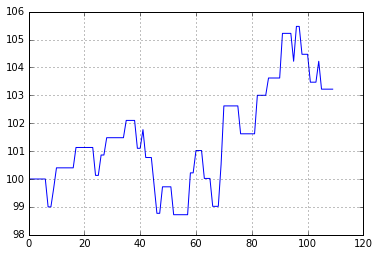

In [48]:
bankroll = 100.0
trace = []
for i in test_report.index:
    stake = 1.0
    # bet on home win
    if test_report.loc[i, 'Predicted Outcome'] == 'A':
        bankroll -= stake
        # win the bet
        if test_report.loc[i, 'True Outcome'] == test_report.loc[i, 'Predicted Outcome']:
            bankroll += stake*test_report.loc[i, test_report.loc[i, 'True Outcome']]
        # lost the bet
        else:
            pass
    trace.append(round(bankroll, 2))

plt.plot(range(len(test_report.index)), trace)
plt.grid()

In [ ]:
# Vanderplas learning curve

from sklearn.datasets import load_boston
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge, Lasso

def plot_learning_curve(model, err_func=explained_variance_score, N=300, n_runs=10, n_sizes=50, ylim=None):
    sizes = np.linspace(5, N, n_sizes).astype(int)
    train_err = np.zeros((n_runs, n_sizes))
    validation_err = np.zeros((n_runs, n_sizes))
    for i in range(n_runs):
        for j, size in enumerate(sizes):
            xtrain, xtest, ytrain, ytest = train_test_split(
                X, y, train_size=size, random_state=i)
            # Train on only the first `size` points
            model.fit(xtrain, ytrain)
            validation_err[i, j] = err_func(ytest, model.predict(xtest))
            train_err[i, j] = err_func(ytrain, model.predict(xtrain))

    plt.plot(sizes, validation_err.mean(axis=0), lw=2, label='validation')
    plt.plot(sizes, train_err.mean(axis=0), lw=2, label='training')

    plt.xlabel('traning set size')
    plt.ylabel(err_func.__name__.replace('_', ' '))
    
    plt.grid(True)
    
    plt.legend(loc=0)
    
    plt.xlim(0, N-1)
    
    if ylim:
        plt.ylim(ylim)


X = load_boston().data
y = load_boston().target
plt.figure(figsize=(10, 8))
for i, model in enumerate([Lasso(0.01), Ridge(0.06)]):
    plt.subplot(221 + i)
    plot_learning_curve(model, ylim=(0, 1))
    plt.title(model.__class__.__name__)
    
    plt.subplot(223 + i)
    plot_learning_curve(model, err_func=mean_squared_error, ylim=(0, 8000))
